### READ ME
Purpose: this code allows the user to download GPM IMERG data from GES DISC using a NASA Earthdata account as well as a link list from GES DISC. It also reads in the data and creates a timeseries pandas dataframe of the mean precipitation in each image downloaded.

Requirements:

    -To run this script, the user must have an Earthdata account that's more than 24 hours old. 
    -The user must also have a link list from GES DSIC of the data they want to retrieve.
    -All imported libraries are required to be installed to the environment
        -netcdf4 and h5netcdf dependencies are required to be installed for xarray

### import statements

In [4]:
# verification dependencies
from subprocess import Popen
from getpass import getpass
import platform
import os
import shutil
# data management dependencies
import pandas as pd
import numpy as np
import xarray as xr
import rioxarray as rio
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

### build .netrc, cookie jar, and .dodsrc to verify Earthdata account 

In [ ]:
# earthdata url to call for authentication
urs = 'urs.earthdata.nasa.gov'
# prompts to collect username and password
prompts = ['Enter NASA Earthdata Login Username \n(or create an account at urs.earthdata.nasa.gov): ',
           'Enter NASA Earthdata Login Password: ']

# establish directory
homeDir = os.path.expanduser("~") + os.sep

# write .netrc
with open(homeDir + '.netrc', 'w') as file:
    file.write('machine {} login {} password {}'.format(urs, getpass(prompt=prompts[0]), getpass(prompt=prompts[1])))
    file.close()
# write cookie jar
with open(homeDir + '.urs_cookies', 'w') as file:
    file.write('')
    file.close()
# write .dodsrc
with open(homeDir + '.dodsrc', 'w') as file:
    file.write('HTTP.COOKIEJAR={}.urs_cookies\n'.format(homeDir))
    file.write('HTTP.NETRC={}.netrc'.format(homeDir))
    file.close()

# output where files were saved
print('Saved .netrc, .urs_cookies, and .dodsrc to:', homeDir)

# set appropriate permissions for Linux/macOS
if platform.system() != "Windows":
    Popen('chmod og-rw ~/.netrc', shell=True)
else:
    # copy dodsrc to working directory in Windows  
    shutil.copy2(homeDir + '.dodsrc', os.getcwd())
    print('Copied .dodsrc to:', os.getcwd())

### get images

In [ ]:
# file name of link list .txt downloaded from GES DISC
link_list = 'subset_GPM_3IMERGDL_06_20230627_154125_.txt'
# read link_list using pandas
ll = pd.read_csv(link_list,header=None,sep='\t')[0]
# verify link_list
print(f"{ll[0]}\n{ll[1]}\n{ll[2]}\nlink list length: {len(ll)}")

In [ ]:
for file in range(2, len(ll)): # range 2 because ds[0], ds[1] are documentation files
    # get the url
    URL = ll[file]
    # print request log
    result = requests.get(URL)
    print(result)
    # generate file name
    filename = 'gpm_imerg_precipCal_'+URL[99:107]+'.nc' # url sliced to pull date
    # write file
    with open(filename,'wb') as f:
        f.write(result.content)
    print(ll[file]) # printing each file provides a log of files downloaded

### write average daily precipitation csv

In [ ]:
# use wildcard to open all downloaded images
open_file = 'gpm_imerg_precipCal_*'+'.nc'
xr_df = xr.open_mfdataset(open_file, engine='netcdf4') # open with xr.open_mfdataset
#xr_df = xr_df.rio.set_spatial_dims('Longitude','Latitude')
# create a 2 dimensional array dataframe of time and mean
xr_df_mean = xr_df.mean(dim=['lat','lon']).to_dataframe()
# set the xr datetime index to a pandas datetime index
datetimeindex = xr_df_mean.index.to_datetimeindex()
# add a date column with the pandas datetime
xr_df_mean['date'] = datetimeindex
# reset the index
df_mean = xr_df_mean.reset_index()
# drop the xr datetime
df_mean = df_mean.drop(['time'], axis=1)
# write to csv
df_mean.to_csv('avg_daily_precip.csv', index=False)

### read data into dataframe

In [2]:
df = pd.read_csv('avg_daily_precip.csv')
df['date'] = pd.to_datetime(df['date'])
df = df[['date','precipitationCal']]
df.head(5)

,date,precipitationCal
0,2022-05-01,9.641291
1,2022-05-02,0.015415
2,2022-05-03,21.193977
3,2022-05-04,0.000000
4,2022-05-05,18.103410


### plot time series

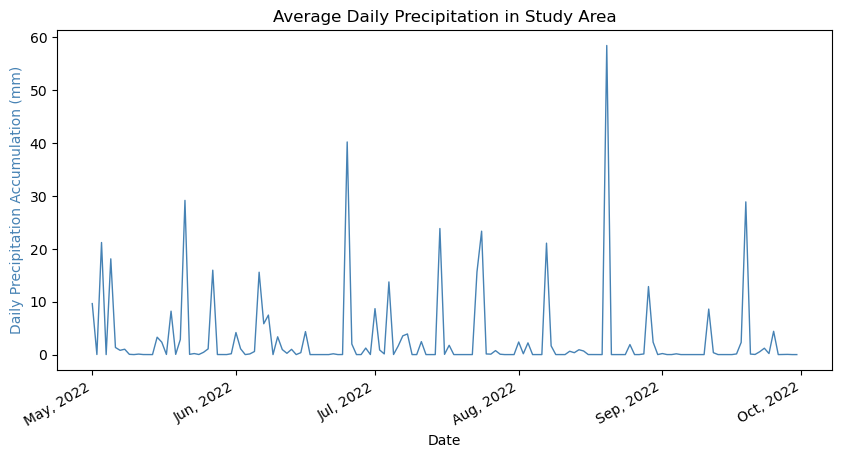

In [6]:

date = df['date']
value = df['precipitationCal']

fig, ax = plt.subplots(figsize=(10, 5))

month_year_formatter = mdates.DateFormatter('%b, %Y')

ax.xaxis.set_major_formatter(month_year_formatter)
ax.set_title('Average Daily Precipitation in Study Area')
ax.set_ylabel('Daily Precipitation Accumulation (mm)', color='steelblue')
ax.set_xlabel('Date')
ax.plot(date, value, color="steelblue",linewidth=1)
# autoformat date
fig.autofmt_xdate()
# display plot
plt.show()